In [3]:
from simple_multi_unet_model import * # Uses softmax as last activation
from supporters import *
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import imageio
import nibabel as nib
import cv2

### Read train and mask files into numpy array

In [4]:
def read_volumetric_data():
    train_path = '../data/MM_WHS/ct_train'
    mask_path = '../data/MM_WHS/ct_train_mask'
    
    train_files = glob.glob(os.path.join(train_path, '*.nii.gz'))
    mask_files = glob.glob(os.path.join(mask_path, '*.nii.gz'))

    train_images = []
    for index_file in range(3):
        pat = sitk.ReadImage(train_files[index_file], sitk.sitkFloat32)
        pat = sitk.GetArrayFromImage(pat)
        for i in range(pat.shape[0]):
            train_images.append(pat[i])
            
    mask_images = []
    for index_file in range(3):
        pat = sitk.ReadImage(mask_files[index_file], sitk.sitkFloat32)
        pat = sitk.GetArrayFromImage(pat)
        for i in range(pat.shape[0]):
            mask_images.append(pat[i])
        
    train_images = np.array(train_images)
    mask_images = np.array(mask_images)
    return train_images, mask_images


train_images, mask_images = read_volumetric_data()
train_images.shape, mask_images.shape

((900, 512, 512), (900, 512, 512))

### Convert Nifti to Folder pngs

In [36]:
# Load the .nii.gz file
image = sitk.ReadImage("../data/MM_WHS/ct_train/ct_train_1001_image.nii.gz")
pat1001 = sitk.GetArrayFromImage(image)

def convert_nii_to_image():
    (z, x, y) = pat1001.shape 
    
    for i in range(z): 
        img = pat1001[i,:,:]
        img = (img - np.min(img)) / np.ptp(img)  # Normalize the data to 0 - 1
        img = 255 * img  # Now scale by 255
        img = img.astype(np.uint8)
        imageio.imsave(f'../data/MM_WHS/ct_train/ct_train_1001_image/{str(i).zfill(3)}.png', img)
        
convert_nii_to_image()

# Specify the path
path = '../data/MM_WHS/ct_train/ct_train_1001_image'

# Use glob to match the pattern '*.png', and sort the files
files = sorted(glob.glob(os.path.join(path, '*.png')))

train_images = []
for file in files:
    img = cv2.imread(file, 0)   
    train_images.append(img)   
    
train_images = np.array(train_images)

In [ ]:
explore_3D_array_comparison(train_images, pat1001)

### Encoding

In [3]:
# 8 pixel values -> background + 7 classes
np.unique(mask_images)

array([  0., 205., 420., 500., 550., 600., 820., 850.], dtype=float32)

In [5]:
# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_images.shape
mask_images_reshaped = mask_images.reshape(-1,1)

mask_images_reshaped_encoded = labelencoder.fit_transform(mask_images_reshaped)
mask_images_encoded_original_shape = mask_images_reshaped_encoded.reshape(n, h, w)
np.unique(mask_images_encoded_original_shape)

e:\Github\VascuIAR\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [6]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_inputs = np.expand_dims(mask_images_encoded_original_shape, axis=3)

train_images.shape, train_masks_inputs.shape

((900, 512, 512, 1), (900, 512, 512, 1))

In [14]:
# after normalization
np.max(train_images), np.min(train_images), np.max(train_masks_inputs), np.min(train_masks_inputs)

(0.38129026, -0.37567228, 7, 0)

### Splitting data

In [7]:
n_classes = 8
'''
Create a subset of data for quick testing
Picking 10% for testing and remaining for training (train set + validation set)
'''

from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_inputs, test_size = 0.1, random_state = 0)

# Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4 5 6 7]


In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(np.max(X_train), np.min(X_train), np.max(y_train), np.min(y_train))

(648, 512, 512, 1) (90, 512, 512, 1) (648, 512, 512, 1) (90, 512, 512, 1)


0.38129026 -0.37567228 7 0


In [9]:
n_classes = 8
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [18]:
y_train_cat.shape, y_test_cat.shape

((648, 512, 512, 8), (90, 512, 512, 8))

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(mask_images_reshaped_encoded),
                                                 mask_images_reshaped_encoded)
print("Class weights are...:", class_weights)

In [25]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# can replace with focal loss
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512, 512, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [27]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test_cat), 
                    # class_weight=class_weights,   
                    shuffle=False)

Epoch 1/10
 2/41 [>.............................] - ETA: 34:32 - loss: 2.0216 - accuracy: 0.0750

In [ ]:
# save the model
model.save('model/model_multi_v1.hdf5')

# Evaluate the model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

### Metrics Visualization

In [ ]:
# Visualize metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Intersection over Union

In [ ]:
model.load_weights('model/model_multi_v1.hdf5')  

# IOU (Intersection over UNion)
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0] / (values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1] / (values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2] / (values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3] / (values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(mask_images[0], cmap='gray')

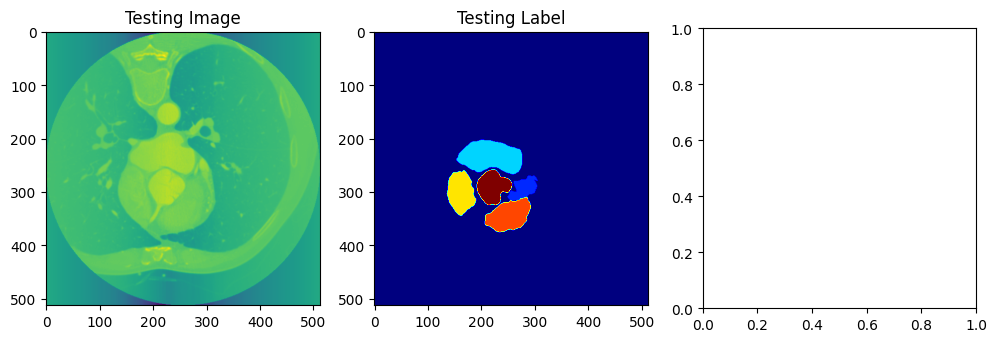

In [12]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)
# prediction = (model.predict(test_img_input))
# predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
# Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('large_images/large_image.tif', 0)
# This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  # Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
plt.imsave('imgs/seg.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  # Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()